In [19]:
import pandas as pd
import unidecode
import string
import sklearn.feature_extraction
import itertools
from langdetect import detect
from langdetect import DetectorFactory
#DetectorFactory.seed = 0
from tqdm import tqdm
import re
import seaborn as sns
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from normalise import normalise
import numpy as np
import preprocessor as p
debug = lambda x: print(x)

In [2]:
rm_punc = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS

In [3]:
temp_word = set(stop_words)
new_words_temp = ["RT","new", "...", "I", "http"] #<<<< ADD MORE HERE
for i in new_words_temp:
    temp_word.add(i)
stop_words = frozenset(temp_word)

In [14]:
tweets = pd.read_json('/Users/tomashegewisch/Downloads/030110/LIM368_20200307.json', lines=True, orient='record')
#tweets = pd.read_json('/Users/tomashegewisch/Downloads/030110/test.json', lines=True, orient='record')

pd.set_option('display.max_rows', tweets.shape[0]+1)

In [20]:
debug("BEFORE")
debug(len(tweets))
tweets.drop_duplicates(subset=['id'], keep="first", inplace=True)
debug("\nAFTER")
debug(len(tweets))

BEFORE
779

AFTER
779


In [6]:
tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [24]:
tweets['time'][1]

'23:09:34'

In [8]:
def clean_tweet_word(word):
    if (len(word) > 1) and (word[0] == '#' or word[0] == '@'):
        return word[0] + word[1:].translate(rm_punc).strip()
    if word.startswith('http') or word.startswith('pic.twitter.com') or word.endswith('.com') or word.endswith('.co.za'):
        return ''
    if word in stop_words:
        return ''
    return word.translate(rm_punc).strip()

def clean_tweet(tweet):
    tweet = unidecode.unidecode(tweet).lower().split()
    tweet = [clean_tweet_word(x) for x in tweet]
    tweet = list(itertools.chain.from_iterable([x.split() for x in tweet if x != '']))
    tweet = [x for x in tweet if len(x) > 1]
    return tweet

In [9]:
# we want to get rid of all the tweets that do not have english in them
# print("The length of the DF(before): " + str(len(tweets)))
# non_text = 0
# non_en = 0
# temp_list_non_eng = []
# for i in tqdm(tweets['tweet'].tolist()):
#     try:
#         value = detect(i)
#         if value != "en":
#             temp_list_non_eng.append(i)
#     except:
#         non_text +=1
# print("Non-Recognisable text: " + str(non_text))        
# print("we found: "+str(len(temp_list_non_eng))+ " non-eng tweets")

# for i in temp_list_non_eng:
#     tweets = tweets[tweets.tweet != i]
    
# print("The length of the DF(after): " + str(len(tweets)))

  0%|          | 0/1117 [00:00<?, ?it/s]

The length of the DF(before): 1117


100%|██████████| 1117/1117 [00:15<00:00, 72.54it/s]


Non-Recognisable text: 166
we found: 340 non-eng tweets
The length of the DF(after): 777


In [9]:
def language(text):
    try:
        return detect(text)
    except:
        return "en" 

In [15]:
#lanagauges = tweets['tweet'].apply(lanagauge)
#tweets['lanagauges'] = lanagauges
#TODO:Drop the non-English words
lanagauge("37Nna ke re kgane o lemogile gore team eo ya ren...")
print(len(tweets))
tweets = tweets[tweets['tweet'].apply(language) == "en"]
print(len(tweets))

1117
779


In [10]:
# phone number
#txt = "The rain in Spain 0218879544"
#re.findall("\d+", txt)
for i in tweets['tweet']:
    for j in re.findall("\d+", i):
        if len(j) == 10:
            print(j)

1477000386
0794172654
0734307920


In [11]:
tokinized = tweets['tweet'].apply(clean_tweet)

In [12]:
tfidf_transform = sklearn.feature_extraction.text.TfidfVectorizer(analyzer=clean_tweet, min_df=0.01)
X = tfidf_transform.fit_transform(tweets['tweet'])

In [13]:
tfidf_transform.get_feature_names()

['#absaprem',
 '#eababanights',
 '#ultimateloveng',
 'africa',
 'baroka',
 'black',
 'campus',
 'can',
 'come',
 'day',
 'did',
 'don',
 'eish',
 'fc',
 'good',
 'hope',
 'it',
 'just',
 'kids',
 'know',
 'leopards',
 'let',
 'like',
 'limpopo',
 'lol',
 'love',
 'mall',
 'need',
 'north',
 'people',
 'polokwane',
 're',
 'south',
 'team',
 'thank',
 'that',
 'time',
 'today',
 'turfloop',
 'win',
 'ya',
 'yes',
 'you']

In [14]:
#tokinized
tweets['tokinized'] = tokinized

In [15]:
print(tweets['tweet'][1000])
print(tweets['tokinized'][1000])

#KeaDrive
['#keadrive']


In [16]:
# importing NLTK stuff manualy
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [17]:
text = ["0218879544", "27", "500billion", "SABC"]
normalised_words = normalise(text, verbose=False)
normalised_words

['two hundred and eighteen million, eight hundred and seventy nine thousand, five hundred and forty four',
 'twenty seven',
 'five hundred billion',
 'S A B C']

In [18]:
def normalise_func(tok_words_list):
    return normalise(tok_words_list, verbose=False)

In [19]:
normalised = tweets['tokinized'].apply(normalise_func)

In [20]:
tweets['normalised'] = normalised

In [48]:
words = tweets['tokinized'].tolist()
words = [item for sublist in words for item in sublist]

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(100),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

                 Frequency
Word                      
it                      31
just                    22
like                    21
polokwane               21
people                  20
you                     17
limpopo                 17
don                     16
time                    16
know                    15
baroka                  14
black                   14
team                    13
love                    13
leopards                13
need                    12
re                      12
#ultimateloveng         12
fc                      12
mall                    11
good                    11
#absaprem               11
eish                    11
win                     10
let                     10
thank                   10
come                    10
hope                     9
lol                      9
today                    9
did                      9
that                     9
#eababanights            9
can                      9
turfloop                 9
n

In [59]:
# this is using the preprocessor libaray That we found on the intenet.
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER)
def preprocessing_func(tweet_text):
    try:
        return p.clean(str(tweet_text))
    except:
        print(tweet_text)

In [63]:
preprocessing_output = tweets['tweet'].apply(preprocessing_func)

In [76]:
preprocessing_func("BRo 😂😂 1235271459259518979")

'BRo'

In [67]:
tweets.to_pickle("test.pkl")

In [68]:
df = pd.read_pickle("test.pkl")

In [138]:
# Using the tweet-preprocessor library to do initial preprocessing
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER) 
# Should we remove mentions and hashtags? 
# Need to keep track of people like government officials; have a column in dataframe dedicated to hashtags
def preprocessing_func(text):
    print(type(text)) 
    return p.clean(str(tweet['tweet']))
        
def clean_tweet(tweet):
    tweet = preprocessing_func(tweet)
    return tweet

In [139]:
preprocessing_func("hey")
clean_tweet("JEy")
#p.clean(str("hey bro, WHat is your name... 😂😂 12352714"))
#t = clean_tweet("hey bro, WHat is your name... 😂😂 12352714")

<class 'str'>


TypeError: string indices must be integers

In [140]:
def run(t):
    print( type(t) )
def hi(test):
    run(test)
    
hi("hey")

<class 'str'>


In [39]:
# Removal of numbers <- turn this into a function
#for i in tweets['tweet']:
#    for j in re.findall("\d+", i):
#        if len(j) == 10:
#            print(j)
            
def remove_number_from_word(word):
    if re.search("\d+", word) is None:
        return word
    else:
        return ""
        
remove_number_from_word("hei")
#type(re.search("\d+", "yo"))

'hei'

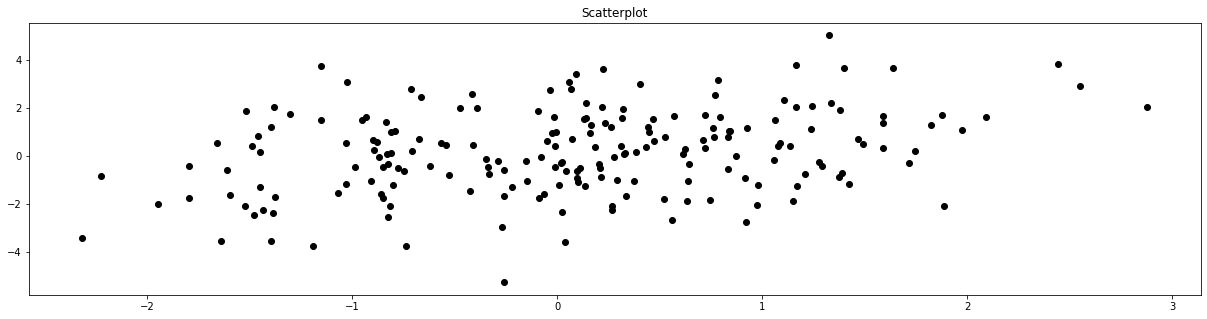

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
 
# Create data: 200 points
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
x, y = data.T
 
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(21, 5))
 
# Everything sarts with a Scatterplot
axes.set_title('Scatterplot')
axes.plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!